In [2]:
import numpy as np
import pandas as pd
import os
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from numpy.linalg import pinv


In [3]:
file_path = "/homeL/1sliu/code/HMM/CPA/data/CPA_Data_IntroductionToMarketing_2023_Fall_Group_44.xlsx"

# Read the Excel file into a Pandas DataFrame
clv_data = pd.read_excel(file_path)

11 cohorts -> user grouping
how many unique users?
whats recency?->how recently a customer engaged
bounce? -> turn away rate after just opening one page


Q1 Understanding the Context:

The assumption that Netflix has a contractual relationship with its customers is reasonable considering the nature of the Subscription-Video-On-Demand (SVOD) industry. Customers typically pay for access to streaming content on a recurring monthly or annual basis, which constitutes a contractual agreement where continued access is contingent upon regular payments. This subscription model ensures a predictable and steady revenue stream for the company and necessitates a certain level of commitment from the customer, differentiating it from non-contractual relationships where transactions are one-off or irregular. Additionally, this contractual bond allows for more accurate customer lifetime value (CLV) predictions, as the duration and value of the customer relationship are more defined and measurable.


2a:How many different users did Netflix acquire during the one-year time window, i.e., what is the total size of the customer base in the dataset?

In [4]:
total_unique_users = clv_data['user'].nunique()
print(total_unique_users)

20271


2b: How many (new) users did Netflix acquire each month—i.e., what were the initial sizes of the 12 different cohorts? 

cohort
0     1792
1     1561
2     1948
3     2050
4     1589
5     2322
6     1374
7     1264
8     1431
9     1617
10    1891
11    1432
Name: user, dtype: int64


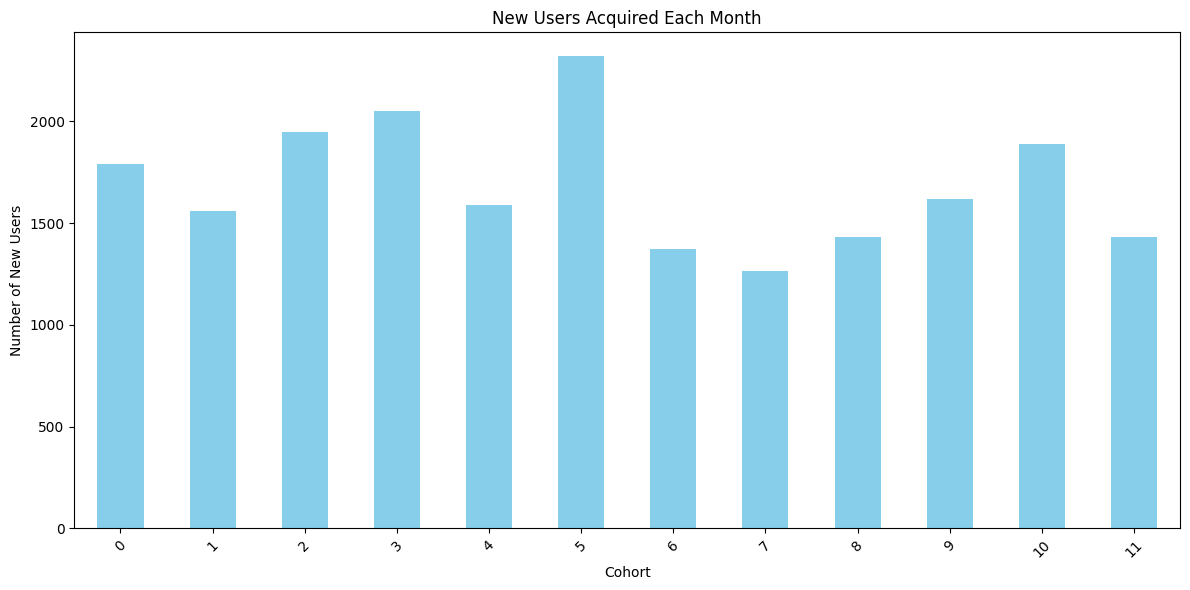

In [5]:
# Task 2-b: Count of new users acquired each month (initial sizes of the cohorts)
new_users_per_month = clv_data.groupby('cohort')['user'].nunique()
print(new_users_per_month)

# Visualization of new users acquired each month
plt.figure(figsize=(12, 6))
new_users_per_month.plot(kind='bar', color='skyblue')
plt.title('New Users Acquired Each Month')
plt.xlabel('Cohort')
plt.ylabel('Number of New Users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2d: How many users were there in each month of the observation window (i.e., size of customer
base over time)?

year_month
2017-11    1792
2017-12    2723
2018-01    3155
2018-02    3349
2018-03    3154
2018-04    3263
2018-05    2747
2018-06    2096
2018-07    1663
2018-08    2311
2018-09    2933
2018-10    2946
Name: user, dtype: int64


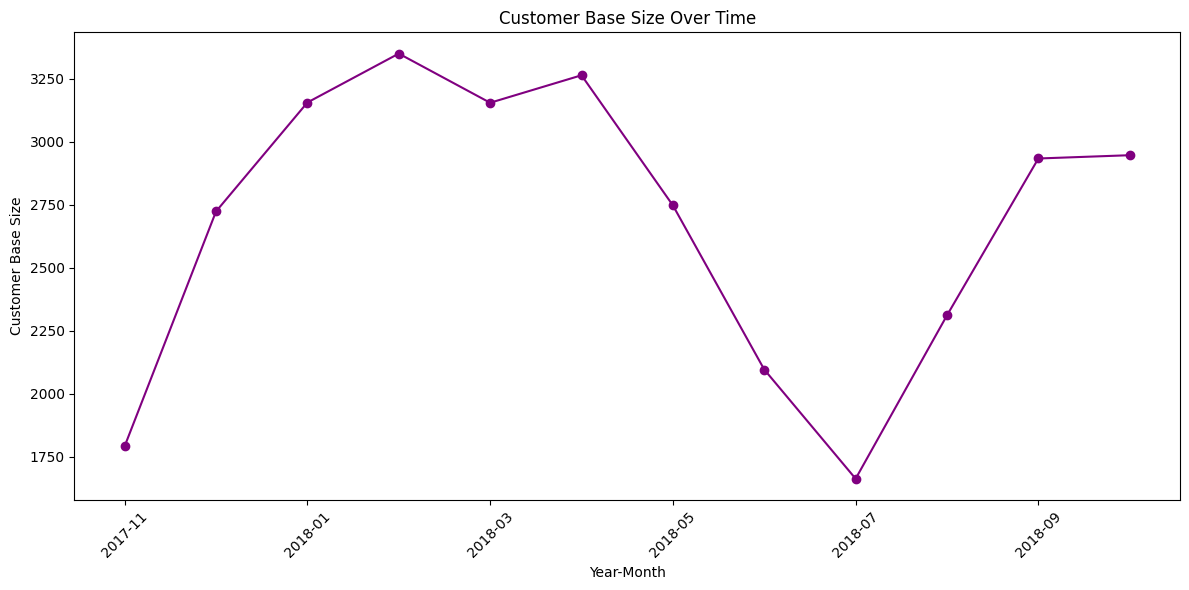

In [6]:

# Create a column 'year_month' to help with aggregation
clv_data['year_month'] = clv_data['time_year'].astype(str) + '-' + clv_data['time_month'].astype(str).str.zfill(2)
customer_base_over_time = clv_data.groupby('year_month')['user'].nunique()

print(customer_base_over_time)

# Visualization of customer base size over time
plt.figure(figsize=(12, 6))
customer_base_over_time.plot(kind='line', marker='o', color='purple')
plt.title('Customer Base Size Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Customer Base Size')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
total_unique_users = clv_data['user'].nunique()
start_time = clv_data[['time_year', 'time_month']].min()

print(total_unique_users)

20271


Q3
a: Calculate the retention rate of customers acquired in month zero (0) (i.e., cohort 0) at each
month of the time window

b:Plot the retention rate (y-axis) against time (x-axis) and describe your results.


users of cohort along month 0     1792
1     1162
2       68
3       24
4        9
      ... 
61     812
62     101
63    1891
64    1370
65    1432
Name: retention_count, Length: 66, dtype: int64
period_number
0     1.000000
1     0.648438
2     0.037946
3     0.013393
4     0.005022
5     0.004464
6     0.003348
7     0.001674
8     0.000558
9     0.000558
10    0.000558
Name: 0, dtype: float64
cohort: 0


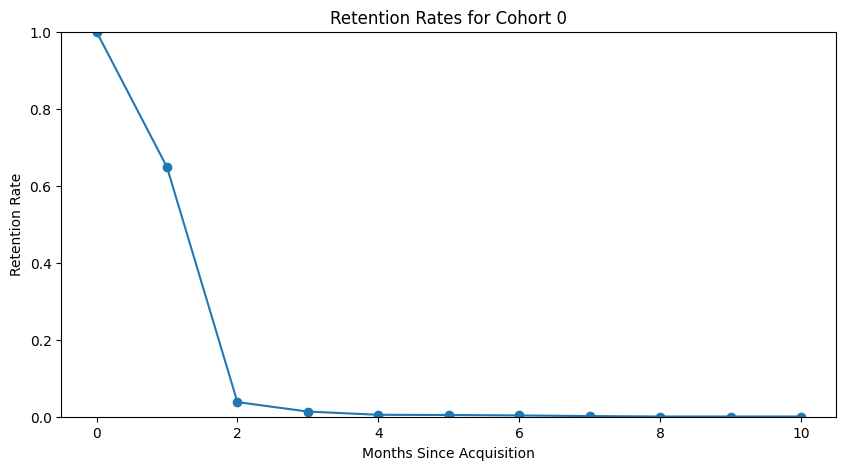

In [41]:
#import pandas as pd

def calculate_retention_rates(data, cohort_column='cohort', user_column='user', time_column='year_month'):
    """
    Calculate the retention rate for each cohort at each month.
    """
    # Convert 'year_month' to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(data[time_column]):
        data[time_column] = pd.to_datetime(data[time_column], format='%Y-%m')

    # Get the total number of users in each cohort at the starting point (month 0)
    cohort_sizes = data.groupby(cohort_column)[user_column].nunique().rename('cohort_size')
    #print("cohort sizes", cohort_sizes)
    
    # Merge the cohort sizes back onto the original data
    data = data.merge(cohort_sizes.reset_index(), on=cohort_column)
    
    # Create a period number for each user within each cohort
    data['period_number'] = (
        data[time_column] - data.groupby(user_column)[time_column].transform('min')
    ).dt.days // 30  # Approximate the number of months
    
    # Calculate retention count by cohort and period
    retention = data.groupby([cohort_column, 'period_number'])[user_column].nunique().rename('retention_count')
    retention = retention.reset_index()
    retention = retention.merge(cohort_sizes.reset_index(), on=cohort_column)

    print("users of cohort along month", retention['retention_count'])      #len = 66?    have retention['retention_count'] printed out fully sideways
    
    # Calculate the retention rate
    retention['retention_rate'] = retention['retention_count'] / retention['cohort_size']
    
    return retention.pivot(index=cohort_column, columns='period_number', values='retention_rate')

def plot_retention_rates(retention_rates, cohort=0):
    """
    Plot the retention rates for a single cohort.
    """
    print("cohort:", cohort)
    cohort_data = retention_rates.loc[cohort]
    plt.figure(figsize=(10, 5))
    plt.plot(cohort_data.index, cohort_data.values, marker='o')
    plt.title(f'Retention Rates for Cohort {cohort}')
    plt.xlabel('Months Since Acquisition')
    plt.ylabel('Retention Rate')
    plt.ylim(0, 1)
    plt.show()


# Example usage:
retention_rates = calculate_retention_rates(clv_data)
print(retention_rates.loc[0])
plot_retention_rates(retention_rates, cohort=0)

3a: 2nd implementation

Number of users for each month in cohort 0:
period_number
0     1.000000
1     0.648438
2     0.037946
3     0.013393
4     0.005022
5     0.004464
6     0.003348
7     0.001674
8     0.000558
9     0.000558
10    0.000558
Name: retention_count, dtype: float64


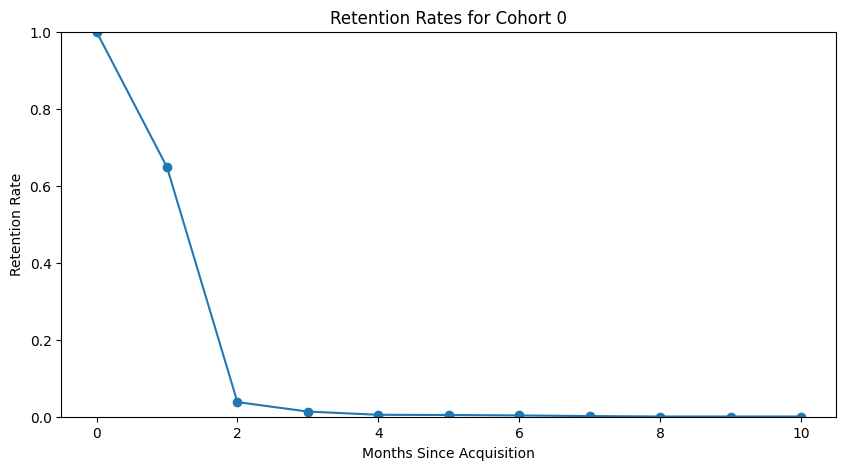

In [32]:
def calculate_cohort0_retention(data):
    # Identify the initial users in cohort 0
    cohort0_users = data[data['cohort'] == 0]['user'].unique()
    
    # Find the initial size of cohort 0
    initial_size = len(cohort0_users)
    
    # Calculate retention by checking the presence of cohort 0 users in each month
    retention = data[data['user'].isin(cohort0_users)].groupby('time_month')['user'].nunique()

    print(retention)
    
    # Divide by the initial size to get the retention rate
    retention_rate = retention / initial_size
    
    # Fill in any missing months with 0 retention (if any)
    all_months = pd.date_range(start=min(data['time_month']), end=max(data['time_month']), freq='MS').strftime('%Y-%m')
    retention_rate = retention_rate.reindex(all_months, fill_value=0)
    
    return retention_rate

# Assuming your DataFrame is named clv_data and the columns are named as described
retention_rates_cohort0 = calculate_cohort0_retention(clv_data)
print(retention_rates_cohort0)


3-c* Compute the average of the monthly retention rates of cohort 0 from part 3a*



In [9]:


def calculate_average_retention_rate(retention_rates):
    """
    Calculate the average retention rate across all months for all cohorts.
    """
    return retention_rates.mean(axis=1)

avg_retention_rate = calculate_average_retention_rate(retention_rates)

print(avg_retention_rate[0])   #answer only for cohort 0

0.15599634740259744


3e:Repeat the calculation of the monthly retention rates from parts 3-a* and 3-c*
for the remaining cohorts, i.e., cohorts 1,..., 11.

In [10]:
print(retention_rates)    #for all retention rates for all cohorts and all months


period_number   0         1         2         3         4         5   \
cohort                                                                 
0              1.0  0.648438  0.037946  0.013393  0.005022  0.004464   
1              1.0  0.729660  0.084561  0.012172  0.005766  0.002562   
2              1.0  0.586756       NaN  0.020021  0.010267  0.004620   
3              1.0  0.075610  0.012195       NaN  0.003902  0.001463   
4              1.0  0.459408  0.033984  0.010069  0.000629       NaN   
5              1.0  0.544358  0.092593  0.003015  0.001723  0.000861   
6              1.0  0.420670  0.007278  0.002911  0.001456       NaN   
7              1.0  0.163766  0.015032  0.005538  0.000791       NaN   
8              1.0  0.462614  0.150245  0.027952       NaN       NaN   
9              1.0  0.502165  0.062461       NaN       NaN       NaN   
10             1.0  0.724484       NaN       NaN       NaN       NaN   
11             1.0       NaN       NaN       NaN       NaN      

3-e* 2 AVERAGE Repeat the calculation of the monthly and average retention rates from parts 3-a* and 3-c*
for the remaining cohorts, i.e., cohorts 1,..., 11

In [11]:
print(avg_retention_rate) #row mean for each cohort

cohort
0     0.155996
1     0.262378
2     0.180641
3     0.156376
4     0.300818
5     0.234711
6     0.286463
7     0.237025
8     0.410203
9     0.521542
10    0.862242
11    1.000000
dtype: float64


3g: Calculate the average retention rate for each month across cohorts, i.e., the average
retention rate of users in their 1st, 2nd, ... 12th month after acquisition.

3h: Average the monthly retention rates from part 3-g* across months

In [12]:


def calculate_monthly_average_retention_rate(retention_rates):

    #print("mean ret rateeeeee", retention_rates.mean)
    """
    Calculate the average retention rate for each month across all cohorts.
    """
    return retention_rates.mean(axis=0)

avg_retention_rate = calculate_average_retention_rate(retention_rates)

print(avg_retention_rate) 
mean_retention_rate = avg_retention_rate.mean()
print("3h:",mean_retention_rate)

cohort
0     0.155996
1     0.262378
2     0.180641
3     0.156376
4     0.300818
5     0.234711
6     0.286463
7     0.237025
8     0.410203
9     0.521542
10    0.862242
11    1.000000
dtype: float64
3h: 0.38403299570729127


extra code

In [13]:

def plot_average_retention_rates(retention_rates):
    """
    Plot the average retention rate for all cohorts.
    """
    avg_retention_rate = calculate_average_retention_rate(retention_rates)
    print("AVGretention ratsssssses", avg_retention_rate)
    plt.figure(figsize=(10, 5))
    plt.bar(x=avg_retention_rate.index, height=avg_retention_rate.values, color='teal')
    plt.title('Average Retention Rate by Cohort')
    plt.xlabel('Cohort')
    plt.ylabel('Average Retention Rate')
    plt.ylim(0, 1)
    plt.show()
def calculate_monthly_average_retention_rate(retention_rates):

    #print("mean ret rateeeeee", retention_rates.mean)
    """
    Calculate the average retention rate for each month across all cohorts.
    """
    return retention_rates.mean(axis=0)


def plot_monthly_average_retention_rate(retention_rates):
    """
    Plot the average retention rate for each month across all cohorts.
    """
    monthly_avg_retention_rate = calculate_monthly_average_retention_rate(retention_rates)
    print("monthly_avg_retention_rate", monthly_avg_retention_rate)
    plt.figure(figsize=(10, 5))
    plt.plot(monthly_avg_retention_rate.index, monthly_avg_retention_rate.values, marker='o', linestyle='-', color='orange')
    plt.title('Monthly Average Retention Rate Across All Cohorts')
    plt.xlabel('Months Since Acquisition')
    plt.ylabel('Average Retention Rate')
    plt.ylim(0, 1)
    plt.show()


monthly_avg_retention_rate = calculate_monthly_average_retention_rate(retention_rates)
#plot_average_retention_rates(retention_rates)  # This will plot the average retention rate by cohort
#plot_monthly_average_retention_rate(retention_rates)  # This will plot the monthly average retention rate
#print(avg_retention_rate, monthly_avg_retention_rate)


q4 excpected lifetime

4a:Compute the expected lifetime of users using the (constant) average retention probability
from part 3-h





In [14]:
def compute_expected_lifetime_constant(retention_rate):
    """
    Compute the expected lifetime using the constant average retention rate.
    """
    if retention_rate == 1:
        return float('inf')  # If the retention rate is 100%, the expected lifetime is infinite.
    return 1 / (1 - retention_rate)

# Use the retention rate from part 3-h
constant_average_retention_rate  = mean_retention_rate  # This should be the value you calculated in 3-h
expected_lifetime_constant = compute_expected_lifetime_constant(constant_average_retention_rate)
print(f"The expected lifetime of users (constant retention): {expected_lifetime_constant}")


The expected lifetime of users (constant retention): 1.6234635833266127


4c:Calculate the expected lifetime of customers by using the (changing) monthly retention rate
of customers in cohort 0 

In [15]:
def compute_lifetime_changing_monthly(retention_rates, cohort=0):
    """
    Compute the expected lifetime using the changing monthly retention rates.
    """
    survival_probability = 1.0
    expected_lifetime = 0.0

    for i in range(len(retention_rates)):
        survival_probability *= retention_rates[i]  # Update survival probability
        expected_lifetime += survival_probability  # Add to expected lifetime

    return expected_lifetime

#Use the retention rates from part 3-a for cohort 0
#retention_rates.loc[0]

retention_rates_cohort_0 = retention_rates.loc[0]  # This should be the array of retention rates for cohort 0
expected_lifetime_changing = compute_lifetime_changing_monthly(retention_rates_cohort_0)
print(f"The expected lifetime of users (changing retention, cohort 0): {expected_lifetime_changing}")


The expected lifetime of users (changing retention, cohort 0): 1.6733745928949892


Question 5 Estimating Survival Probabilities

5-a* Compute the survival probability (i.e., active probability) of the users who were acquired in the first month (i.e., month 0) until the end of the observation window (i.e., month 11). Use the (constant) average retention probability that you have obtained in part 3-c*.



In [67]:
def compute_survival_probability_constant(avg_retention_rate, periods):
    """
    Compute the survival probability using the constant average retention rate.
    """
    return [(avg_retention_rate ** i) for i in range(periods)]

# Example usage:
constant_average_retention_rate = avg_retention_rate[0] # This should be the value you calculated in 3-c
periods = 11  # For the 12 months in the observation window
survival_probabilities_constant = compute_survival_probability_constant(constant_average_retention_rate, periods)


#print(len(survival_probabilities_constant))
print(survival_probabilities_constant)

print(len(survival_probabilities_constant))


[1.0, 0.15599634740259744, 0.024334860402951866, 0.0037961493374125918, 0.0005921854308311548, 9.237876419469365e-05, 1.441074979193806e-05, 2.248024330875078e-06, 3.5068358448868035e-07, 5.470535827428431e-08, 8.533836074138813e-09]
11


5-b* Re-compute the survival probability of users in cohort 0 with the (changing) monthly retention probabilities from part 3-a*

In [68]:
def compute_survival_probability_changing(retention_rates):
    """
    Compute the survival probability using the changing monthly retention rates.
    """
    survival_probabilities = []
    survival_probability = 1.0

    for retention_rate in retention_rates:
        survival_probability *= retention_rate  # Update survival probability
        survival_probabilities.append(survival_probability)

    return survival_probabilities

# Example usage:
retention_rates_cohort_0 = retention_rates.loc[0]  # This should be the array of retention rates for cohort 0 from 3-a

survival_probabilities_changing = compute_survival_probability_changing(retention_rates_cohort_0)

survival_probabilities_changing

print(len(survival_probabilities_changing))



11


5c: Plot the survival probabilities obtained in part 5-a* and 5-b* against time since acquisition. The y-axis shows the survival probability and the x-axis shows time (in months). Additionally, draw two vertical lines that crosses the x-axis at the expected lifetime of customers in cohort 0, which you computed in question 4

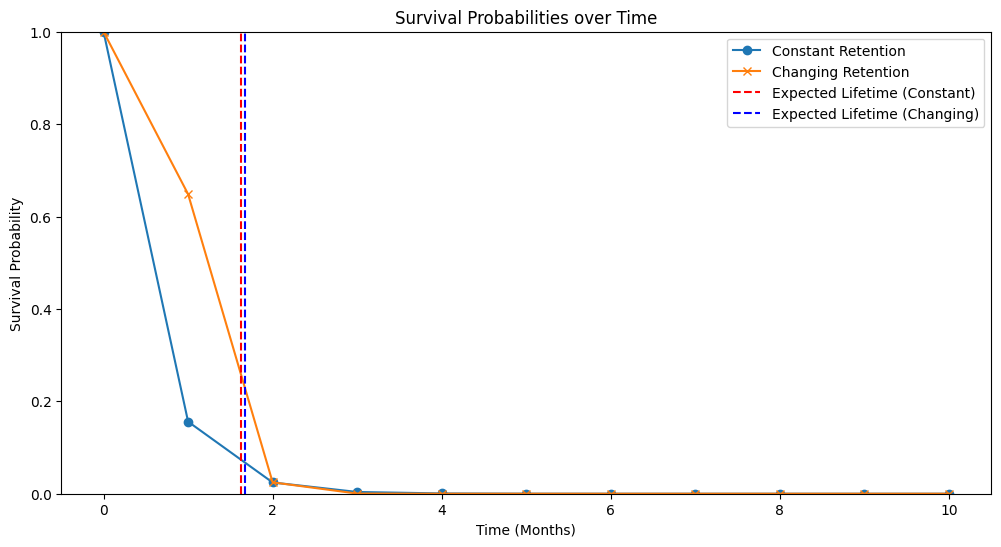

In [71]:
def plot_survival_probabilities(survival_probs_constant, survival_probs_changing, expected_lifetime_constant, expected_lifetime_changing):
    """
    Plot the survival probabilities against time since acquisition.
    """
    months = list(range(len(survival_probs_constant)))
    plt.figure(figsize=(12, 6))
    plt.plot(months, survival_probs_constant, label='Constant Retention', marker='o')
    plt.plot(months, survival_probs_changing, label='Changing Retention', marker='x')

    # Add vertical lines for expected lifetimes
    plt.axvline(x=expected_lifetime_constant, color='red', linestyle='--', label='Expected Lifetime (Constant)')
    plt.axvline(x=expected_lifetime_changing, color='blue', linestyle='--', label='Expected Lifetime (Changing)')

    plt.title('Survival Probabilities over Time')
    plt.xlabel('Time (Months)')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.ylim(0, 1)
    plt.show()


# Example usage:
#survival_probabilities_constant = survival_probabilities_constant#3h
#print(survival_probabilities_constant)

##survival_probabilities_changing = survival_probabilities_changing   #3c
#expected_lifetime_constant = expected_lifetime_constant  # 4a
#expected_lifetime_changing = ...  # 4b
plot_survival_probabilities(survival_probabilities_constant, survival_probabilities_changing, expected_lifetime_constant, expected_lifetime_changing)


6: CLV

6a: ~16.3 USD

6b: yes

6c: 

In [74]:


def compute_clv_constant_retention(monthly_revenue, annual_discount_rate, avg_retention_rate):
    monthly_discount_rate = ((1 + annual_discount_rate) ** (1/12)) - 1
    clv = monthly_revenue / (monthly_discount_rate + (1 - avg_retention_rate))
    print(clv)
    return clv

# Example usage:
monthly_revenue = 16.3  # This should be your estimate for monthly revenue per customer
annual_discount_rate = 0.15
constant_average_retention_rate = avg_retention_rate[0]  #avg const retention rate from 3c:
clv_constant_retention = compute_clv_constant_retention(monthly_revenue, annual_discount_rate, constant_average_retention_rate)



19.048318665324118


6d

In [78]:

def compute_clv_expected_lifetime(monthly_revenue, annual_discount_rate, expected_lifetime):
    monthly_discount_rate = ((1 + annual_discount_rate) ** (1/12)) - 1
    clv = (monthly_revenue * expected_lifetime) / monthly_discount_rate
    
    return clv

# Example usage:
#expected_lifetime = expected_lifetime_constant  # This should be the expected lifetime computed in 4-a 
#expected_lifetime = expected_lifetime_changing  # This should be the expected lifetime computed in  4-c
clv_expected_lifetime_A = compute_clv_expected_lifetime(monthly_revenue, annual_discount_rate, expected_lifetime_constant)

clv_expected_lifetime_C = compute_clv_expected_lifetime(monthly_revenue, annual_discount_rate, expected_lifetime_changing)

print("EL_CLV_const", clv_expected_lifetime_A, "EL_CLV_changing", clv_expected_lifetime_C)



EL_CLV_const 2258.8684656719684 EL_CLV_changing 2328.3140675085306


7
a: CLV of new customer 1 year time horizon


In [84]:
def compute_one_year_clv_old(revenue_per_month, retention_rates, discount_rate_annual):
    discount_rate_monthly = (1 + discount_rate_annual) ** (1/12) - 1
    clv = 0
    for i in range(12):  # 12 months in one year
        clv += (revenue_per_month * retention_rates[i]) / ((1 + discount_rate_monthly) ** i)
    return clv

def compute_one_year_clv(revenue_per_month, retention_rates, discount_rate_annual):
    print(len(retention_rates))
    if len(retention_rates) < 12:
        
        raise ValueError("retention_rates must have 12 elements, one for each month of the year.")
    discount_rate_monthly = (1 + discount_rate_annual) ** (1/12) - 1
    clv = 0
    for i in range(12):  # 12 months in one year
        clv += (revenue_per_month * retention_rates[i]) / ((1 + discount_rate_monthly) ** i)
    return clv


# Calculate customer equity
def calculate_customer_equity(one_year_clv, num_customers):
    return one_year_clv * num_customers

# Example usage:
retention_rates = retention_rates_cohort0  # FROM 3A:  Array of historical retention rates for one year
revenue_per_month = monthly_revenue  # Your estimate of monthly revenue per customer
discount_rate_annual = 0.15


one_year_clv = compute_one_year_clv(revenue_per_month, retention_rates, discount_rate_annual)
customer_equity = calculate_customer_equity(one_year_clv, 10000)


11


ValueError: retention_rates must have 12 elements, one for each month of the year.